# Dự đoán Chất lượng Nước

Chúng ta đều biết nước là một trong những tài nguyên thiết yếu cho sự sống. Tuy nhiên, cùng với sự phát triển, con người đang khai thác và lãng phí nước, đồng thời làm ô nhiễm nguồn nước với các chất độc hại, khiến nước trở nên không tinh khiết và không còn phù hợp để sử dụng. Đây chính là lý do việc đánh giá chất lượng nước trở nên rất quan trọng.

Trong notebook này, mục tiêu là dự đoán Chỉ số Chất lượng Nước (Water Quality Index – WQI) và trạng thái chất lượng nước dựa trên một số thông số ảnh hưởng trực tiếp đến chất lượng nước.

Các bước thực hiện:

Tiền xử lý dữ liệu (Data Cleaning)

Phân tích dữ liệu khám phá (Exploratory Data Analysis – EDA)

Tính toán và tạo thêm các cột vì dữ liệu gốc chưa có sẵn cột phù hợp để dự đoán

Xây dựng 3 mô hình dự đoán bằng Spark ML:

+ Mô hình hồi quy tuyến tính (Linear Regression – không dùng Deep Learning)

+ Mô hình hồi quy tuyến tính có áp dụng Deep Learning

+ Mô hình hồi quy logistic (Logistic Regression)

Thiết lập môi trường
Trước khi bắt đầu, chúng ta cần thay đổi phiên bản Java vì nếu sử dụng phiên bản 11, chúng ta sẽ gặp một số lỗi và không thể sử dụng PySpark một cách bình thường. Vì vậy, chúng ta sẽ xóa Java phiên bản 11 và cài đặt Java phiên bản 8.ĐÂY LÀ DỮ LIỆU CHẤT LƯỢNG NƯỚC CỦA ẤN ĐỘ (DỮ LIỆU CÓ SẴN LẤY TỪ KAGGLE)

In [ ]:
! apt remove -y openjdk-11-jre-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  java-common libpcsclite1
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  ca-certificates-java openjdk-11-jdk-headless openjdk-11-jre-headless
0 upgraded, 0 newly installed, 3 to remove and 35 not upgraded.
After this operation, 258 MB disk space will be freed.
(Reading database ... 126371 files and directories currently installed.)
Removing openjdk-11-jdk-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Removing openjdk-11-jre-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Removing ca-certificates-java (20190909ubuntu1.2) ...
Processing triggers for ca-certificates (20240203~22.04.1) ...
Updating certificates in /etc/ssl/certs...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

updates of cacerts keystore disabled.
done.


In [ ]:
!apt install -y openjdk-8-jdk openjdk-8-jre

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra
  libatk-wrapper-java libatk-wrapper-java-jni libgail-common libgail18
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common librsvg2-common libxt-dev
  libxtst6 libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre-headless
  x11-utils
Suggested packages:
  gvfs libxt-doc openjdk-8-demo openjdk-8-source visualvm libnss-mdns
  fonts-nanum fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra
  libatk-wrapper-java libatk-wrapper-java-jni libgail-common libgail18
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common librsvg2-common libxt-dev
  libxtst6 libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
0

Bây giờ chúng ta sẽ cài đặt pyspark trước.


In [ ]:
!pip install pyspark


Import thư viện

In [ ]:
from google.colab import files

# Chọn file từ máy tính
uploaded = files.upload()

Saving waterquality.csv to waterquality.csv


In [ ]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

Tải dữ liệu lên

Tải dữ liệu lên khung Spark

In [ ]:
df = spark.read.format("csv").option("header", "true").load('/content/waterquality.csv')
gdf = gpd.read_file('/content/Indian_States.shp')

In [ ]:
df.show(5) #Show dữ liệu với 5 dòng đầu tiên

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|  8|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

In [ ]:
df.dtypes # loại của dữ liệu

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

# Data Cleaning

In [ ]:
from pyspark.sql.types import FloatType

Như ở trên, tất cả các cột đều có kiểu dữ liệu chuỗi, nhưng để tính toán chỉ số chất lượng nước, chúng ta cần chuyển đổi chúng sang kiểu dữ liệu float. vậy nên chúng ta sẽ chuyển đổi các cột cần thiết sang kiểu dữ liệu float.

In [ ]:
df = df.withColumn("TEMP",df["TEMP"].cast(FloatType()))
df = df.withColumn("pH",df["pH"].cast(FloatType()))
df = df.withColumn("DO",df["DO"].cast(FloatType()))
df = df.withColumn("CONDUCTIVITY",df["CONDUCTIVITY"].cast(FloatType()))
df = df.withColumn("BOD",df["BOD"].cast(FloatType()))
df = df.withColumn("NITRATE_N_NITRITE_N",df["NITRATE_N_NITRITE_N"].cast(FloatType()))
df = df.withColumn("FECAL_COLIFORM",df["FECAL_COLIFORM"].cast(FloatType()))
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

cột TOTAL_COLIFORM không cần thiết nên chúng em sẽ bỏ cột này.

In [ ]:
#df=df.drop('TOTAL_COLIFORM') # Loại bỏ cột không cần thiết

KeyError: "['TOTAL_COLIFORM'] not found in axis"

Nhóm muốn xóa tất cả các hàng chứa bất kỳ giá trị null nào.Để áp dụng truy vấn SQL, trước tiên chúng ta phải đăng ký bảng tạm ảo (virtual temporary table) và sau đó sẽ thực hiện truy vấn SQL. Nhóm làm điều này vì việc thực hiện các bước làm sạch dữ liệu là rất quan trọng vì nó sẽ giúp mô hình của chúng ta hoạt động tốt hơn.

In [ ]:
df.createOrReplaceTempView("df_sql")

In [ ]:
df_clean = spark.sql('''Select * from df_sql where TEMP is not null and DO is not null
                        and pH is not null and BOD is not null and CONDUCTIVITY is not null
                        and NITRATE_N_NITRITE_N is not null and FECAL_COLIFORM is not null''')

# EDA

Trực quan hóa dữ liệu của nhóm

In [ ]:
df_clean.createOrReplaceTempView("df_sql")


In [ ]:
do = spark.sql("SELECT DO from df_sql")
do = do.rdd.map(lambda row : row.DO).collect()
ph = spark.sql("SELECT pH from df_sql")
ph = ph.rdd.map(lambda row : row.pH).collect()
bod = spark.sql("SELECT BOD from df_sql")
bod = bod.rdd.map(lambda row : row.BOD).collect()
nn = spark.sql("SELECT NITRATE_N_NITRITE_N from df_sql")
nn = nn.rdd.map(lambda row : row.NITRATE_N_NITRITE_N).collect()

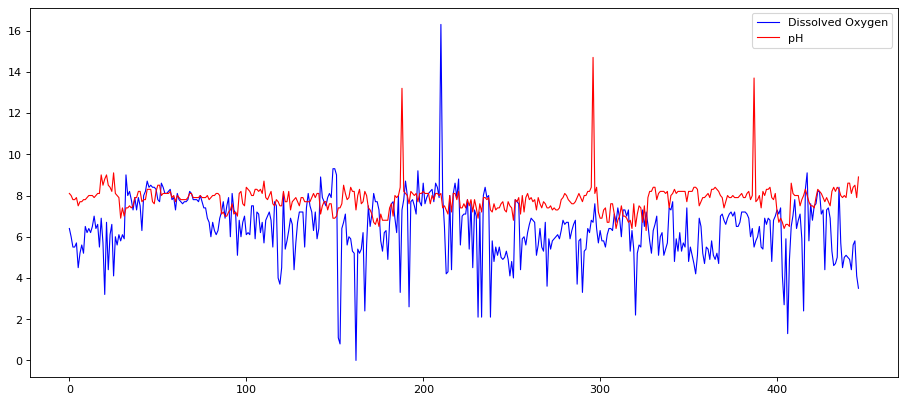

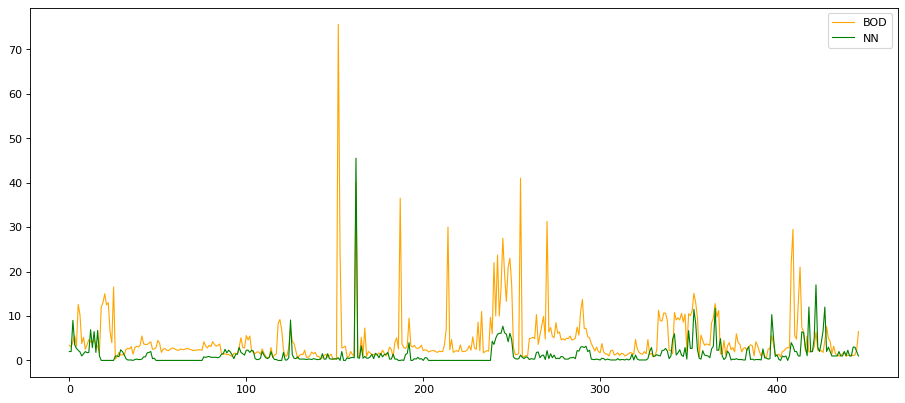

In [ ]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
size=len(do)
ax.plot(range(0,size), do, color='blue', animated=True, linewidth=1, label='Dissolved Oxygen')
ax.plot(range(0,size), ph, color='red', animated=True, linewidth=1, label='pH')
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), bod, color='orange', animated=True, linewidth=1, label='BOD')
ax2.plot(range(0,size), nn, color='green', animated=True, linewidth=1, label='NN')
legend=ax.legend()
legend=ax2.legend()

In [ ]:
con = spark.sql("SELECT CONDUCTIVITY from df_sql")
con = con.rdd.map(lambda row : row.CONDUCTIVITY).collect()
fec = spark.sql("SELECT FECAL_COLIFORM from df_sql")
fec = fec.rdd.map(lambda row : row.FECAL_COLIFORM).collect()

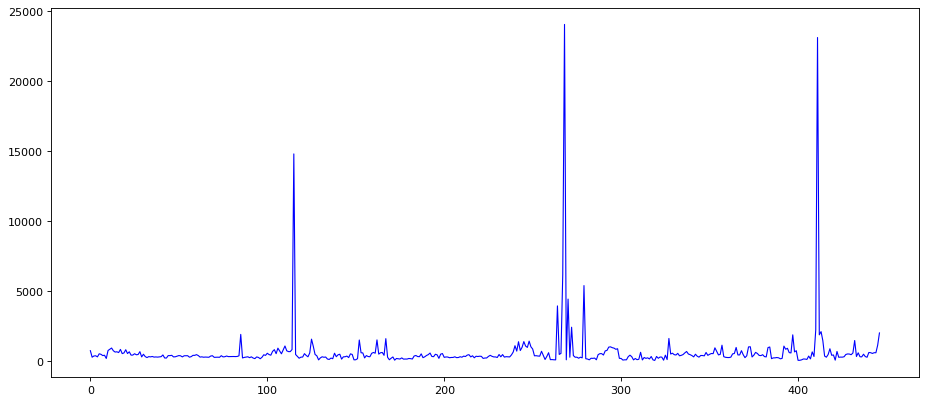

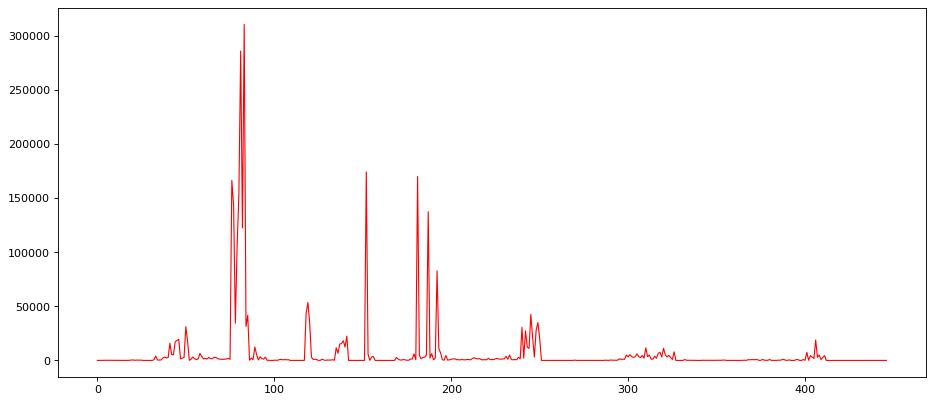

In [ ]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,size), con, color='blue', animated=True, linewidth=1)
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), fec, color='red', animated=True, linewidth=1)

# Kỹ thuật Tính năng
Hãy chuyển đổi dữ liệu sang khung Pandas. Chúng ta làm điều này vì để huấn luyện một mô hình, chúng ta cần những dữ liệu cần dự đoán nhưng lại không có trong dữ liệu. Vì vậy, chúng ta cần tính toán chỉ số chất lượng nước, việc này đòi hỏi nhiều bước nhưng có thể dễ dàng thực hiện bằng Pandas với số bước ít hơn. Ngoài ra, chúng ta cũng có thể trực quan hóa dữ liệu dưới dạng bảng hiệu quả hơn.

In [ ]:
df=df_clean.toPandas()
df.dtypes

,0
STATION CODE,object
LOCATIONS,object
STATE,object
TEMP,float32
DO,float32
pH,float32
CONDUCTIVITY,float32
BOD,float32
NITRATE_N_NITRITE_N,float32
FECAL_COLIFORM,float32


Khởi tạo

In [ ]:
start=0
end=448
station=df.iloc [start:end ,0]
location=df.iloc [start:end ,1]
state=df.iloc [start:end ,2]
do= df.iloc [start:end ,4].astype(np.float64)
value=0
ph = df.iloc[ start:end,5]
co = df.iloc [start:end ,6].astype(np.float64)
bod = df.iloc [start:end ,7].astype(np.float64)
na= df.iloc [start:end ,8].astype(np.float64)
fc=df.iloc [2:end ,9].astype(np.float64)

In [ ]:
df=pd.concat([station,location,state,do,ph,co,bod,na,fc],axis=1)
df. columns = ['station','location','state','do','ph','co','bod','na','fc']

Chỉ số Chất lượng Nước được tính bằng cách cộng tuyến tính xếp hạng chất lượng với trọng số,

WQI = ∑ (qn x Wn)

trong đó qn = Xếp hạng chất lượng cho thông số chất lượng nước thứ n, Wn = trọng số đơn vị cho thông số thứ n.

Mặc dù chúng ta có công thức chuẩn để tính toán qn nhưng trong trường hợp này không thể thực hiện được, vì vậy chúng tôi đã áp dụng phương pháp chuẩn để tính xếp hạng chất lượng cho từng thông số.

In [ ]:
df['npH']=df.ph.apply(lambda x: (100 if (8.5>=x>=7)
                                 else(80 if  (8.6>=x>=8.5) or (6.9>=x>=6.8)
                                      else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7)
                                          else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                              else 0)))))

In [ ]:
df['ndo']=df.do.apply(lambda x:(100 if (x>=6)
                                 else(80 if  (6>=x>=5.1)
                                      else(60 if (5>=x>=4.1)
                                          else(40 if (4>=x>=3)
                                              else 0)))))

In [ ]:
df['nco']=df.fc.apply(lambda x:(100 if (5>=x>=0)
                                 else(80 if  (50>=x>=5)
                                      else(60 if (500>=x>=50)
                                          else(40 if (10000>=x>=500)
                                              else 0)))))

In [ ]:
df['nbdo']=df.bod.apply(lambda x:(100 if (3>=x>=0)
                                 else(80 if  (6>=x>=3)
                                      else(60 if (80>=x>=6)
                                          else(40 if (125>=x>=80)
                                              else 0)))))

In [ ]:
df['nec']=df.co.apply(lambda x:(100 if (75>=x>=0)
                                 else(80 if  (150>=x>=75)
                                      else(60 if (225>=x>=150)
                                          else(40 if (300>=x>=225)
                                              else 0)))))

In [ ]:
df['nna']=df.na.apply(lambda x:(100 if (20>=x>=0)
                                 else(80 if  (50>=x>=20)
                                      else(60 if (100>=x>=50)
                                          else(40 if (200>=x>=100)
                                              else 0)))))

df.head()
df.dtypes

,0
station,object
location,object
state,object
do,float64
ph,float32
co,float64
bod,float64
na,float64
fc,float64
npH,int64


Nhóm áp dụng công thức wqi bằng cách đầu tiên nhân tất cả xếp hạng chất lượng với trọng số của nó và sau đó cộng tất cả các giá trị.

In [ ]:
df['wph']=df.npH * 0.165
df['wdo']=df.ndo * 0.281
df['wbdo']=df.nbdo * 0.234
df['wec']=df.nec* 0.009
df['wna']=df.nna * 0.028
df['wco']=df.nco * 0.281
df['wqi']=df.wph+df.wdo+df.wbdo+df.wec+df.wna+df.wco
df

,station,location,state,do,ph,co,bod,na,fc,npH,...,nbdo,nec,nna,wph,wdo,wbdo,wec,wna,wco,wqi
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",MAHARASHTRA,6.4,8.1,735.0,3.4,2.00,NaN,100,...,80,0,100,16.5,28.10,18.72,0.00,2.8,0.00,66.12
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,MAHARASHTRA,6.0,8.0,270.0,3.1,2.00,NaN,100,...,80,40,100,16.5,28.10,18.72,0.36,2.8,0.00,66.48
2,2182,GODAVARI RIVER AT SAIKHEDA.,MAHARASHTRA,5.5,7.8,355.0,4.2,9.00,59.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",MAHARASHTRA,5.5,7.8,371.0,5.6,3.55,90.0,100,...,80,0,100,16.5,22.48,18.72,0.00,2.8,16.86,77.36
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,MAHARASHTRA,5.7,7.9,294.0,3.2,2.69,45.0,100,...,80,40,100,16.5,22.48,18.72,0.36,2.8,22.48,83.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2940,"GAPE- SAGAR LAKE, DUNGARPUR, RAJASTHAN",RAJASTHAN,4.4,8.1,538.0,1.2,1.00,5.0,100,...,100,0,100,16.5,16.86,23.40,0.00,2.8,28.10,87.66
443,2941,"LAKE JAISAMAND, SALUMBER, UDAIPUR, POINT NO. 1...",RAJASTHAN,5.6,8.4,591.0,1.1,3.00,4.0,100,...,100,0,100,16.5,22.48,23.40,0.00,2.8,28.10,93.28
444,2942,"LAKE JAISAMAND, SALUMBER, UDAIPUR, POINT NO. 2...",RAJASTHAN,5.8,8.5,588.0,1.2,3.00,4.0,100,...,100,0,100,16.5,22.48,23.40,0.00,2.8,28.10,93.28
445,2943,"LODHA TALAB, BANSWARA- DUNGARPUR ROAD, BANSWAR...",RAJASTHAN,4.1,7.9,1133.0,2.3,2.00,7.0,100,...,100,0,100,16.5,0.00,23.40,0.00,2.8,22.48,65.18


Sau đó, nhóm phân loại nước dựa trên chỉ số chất lượng nước của chúng.

In [ ]:
df['quality']=df.wqi.apply(lambda x:('Excellent' if (25>=x>=0)
                                 else('Good' if  (50>=x>=26)
                                      else('Poor' if (75>=x>=51)
                                          else('Very Poor' if (100>=x>=76)
                                              else 'Unsuitable')))))

Hãy cùng hình dung chỉ số chất lượng nước ở từng tiểu bang của Ấn Độ.

In [ ]:
#renaming state names
gdf['st_nm'].replace({"Andaman & Nicobar Island": "Andaman and Nicobar Islands",
                      "Arunanchal Pradesh": "Arunachal Pradesh",
                      'Dadara & Nagar Havelli':'Dadra and Nagar Haveli and Daman and Diu',
                      'Jammu & Kashmir':'Jammu and Kashmir',
                      'NCT of Delhi':'Delhi'}, inplace=True)
df['state'].replace({"TAMILNADU": "TAMIL NADU"}, inplace=True)

#Capitalizing only the first letter of each word
df['state'] = df['state'].str.title()

In [ ]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 33.3 MB/s eta 0:00:00


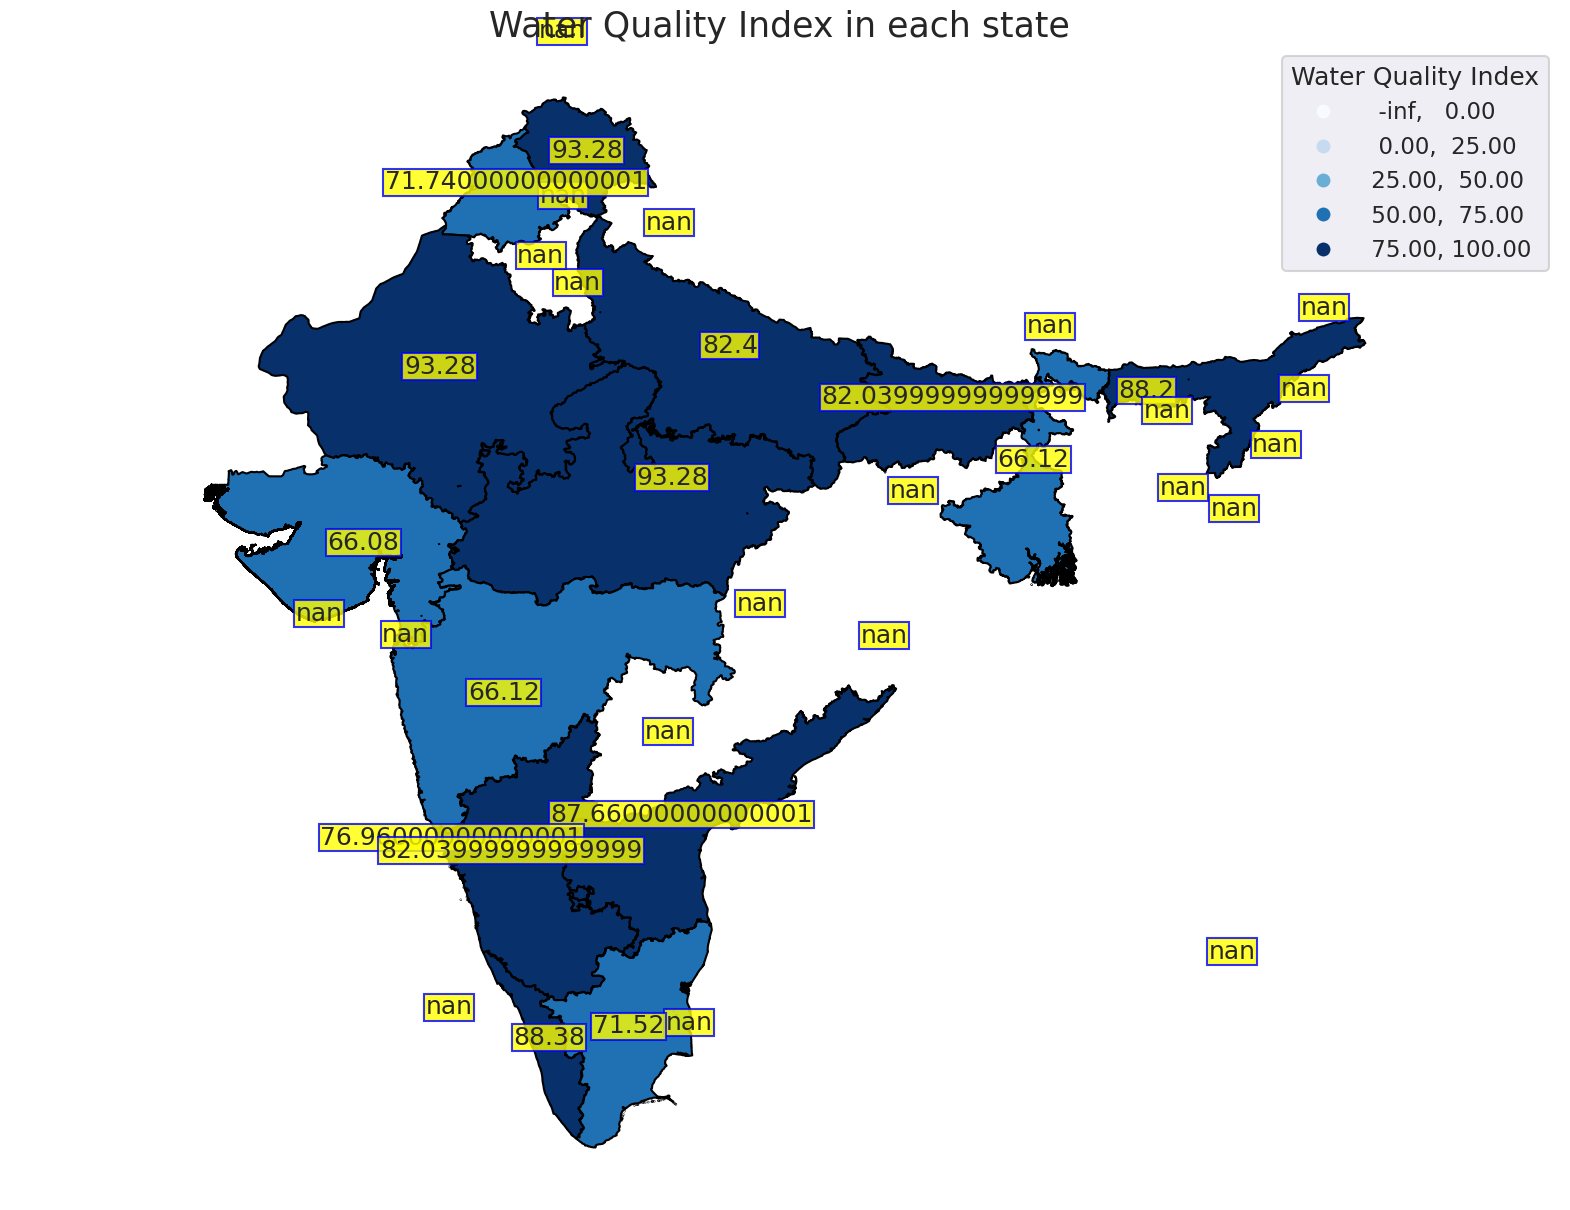

In [ ]:
gdf = gdf.rename(columns={"st_nm": "state"})
merged = pd.merge(gdf, df , how='outer', on='state')
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged = merged.drop_duplicates(subset ="state")

sns.set_context("talk")
sns.set_style("dark")
cmap = 'Blues'
figsize = (20, 15)
ax = merged.plot(column= 'wqi', cmap=cmap,
                          figsize=figsize, scheme='User_Defined',
                          classification_kwds=dict(bins=[0,25,50,75,100]),
                          edgecolor='black', legend = True)
for idx, row in merged.iterrows():
    ax.text(row.coords[0], row.coords[1], s=row['wqi'], horizontalalignment='center', bbox={'facecolor': 'yellow', 'alpha':0.8, 'pad': 1, 'edgecolor':'blue'})

ax.get_legend().set_title('Water Quality Index')
ax.set_title("Water Quality Index in each state ", size = 25)

ax.set_axis_off()
plt.axis('equal')
plt.show()

Chúng ta hãy chuyển đổi lại toàn bộ dữ liệu trong khung tia lửa để thực hiện các quy trình tiếp theo.

In [ ]:
spark_df = sqlContext.createDataFrame(df)


In [ ]:
spark_df.show()


+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|station|            location|         state|               do|               ph|   co|               bod|                na|   fc|npH|ndo|nco|nbdo|nec|nna|               wph|               wdo|              wbdo|               wec|               wna|               wco|              wqi|  quality|
+-------+--------------------+--------------+-----------------+-----------------+-----+------------------+------------------+-----+---+---+---+----+---+---+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|   1312|GODAVARI AT JAYAK...|   Maharashtra|6.400000095367432|8.100000381469727|735.0|3.40000009536743

In [ ]:
spark_df.createOrReplaceTempView("df_sql")


In [ ]:
State = spark.sql("SELECT state from df_sql")
State = State.rdd.map(lambda row : row.state).collect()

In [ ]:
Wqi = spark.sql("SELECT wqi from df_sql")
Wqi = Wqi.rdd.map(lambda row : row.wqi).collect()

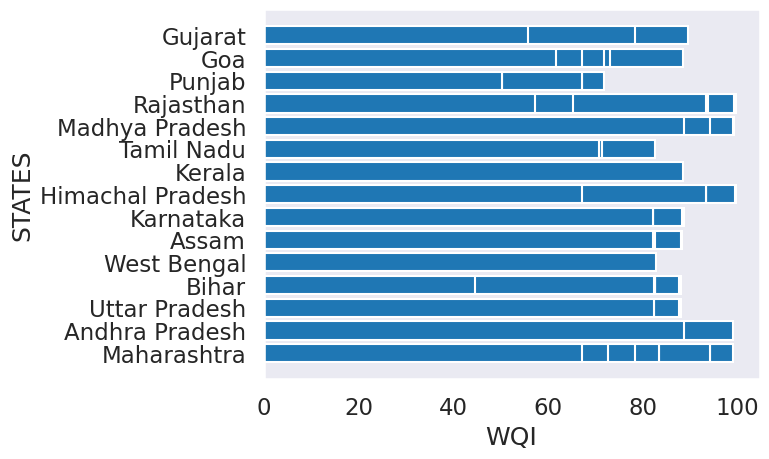

In [ ]:
plt.barh(State,Wqi)

plt.xlabel("WQI")
plt.ylabel("STATES")


plt.show()

# Tạo Mô hình

Bây giờ chúng ta áp dụng các thuật toán học máy và học sâu để dự đoán dữ liệu.

# Mô hình Hồi quy Tuyến tính Không dựa trên Học sâu

Trong mô hình này, dữ liệu đầu tiên cần thiết để dự đoán WQI được chuyển đổi sang dạng vector bằng cách sử dụng VectorAssembler. Sau đó, chúng ta chuẩn hóa dữ liệu bằng cách sử dụng Normalizer.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

vectorAssembler = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco"], outputCol="features")
normalizer = Normalizer(inputCol="features",outputCol="features_norm")

Sau đó, nhập LinearRegression từ pyspark.ml.regression và áp dụng nó vào dữ liệu đã chuẩn hóa của chúng tôi. Sau đó, nhập Pipeline từ pyspark.ml và đưa tất cả các bước đã thực hiện vào pipeline.¶

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features_norm",labelCol="wqi",maxIter=10,regParam=0.3,elasticNetParam=0.2)

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
pipeline = Pipeline(stages=[vectorAssembler,normalizer,lr])

Trước khi đào tạo, dữ liệu của chúng tôi được chia ngẫu nhiên thành hai phần để tránh quá khớp và sau đó quá trình đào tạo được thực hiện.

In [ ]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])

In [ ]:
model = pipeline.fit(train_data)

In [ ]:
predictions = model.transform(train_data)

In [ ]:
predictions.select("wqi","prediction").show()

+-----------------+-----------------+
|              wqi|       prediction|
+-----------------+-----------------+
|82.03999999999999|81.94309941480844|
|             82.4|81.66421029815467|
|             82.4|81.66421029815467|
|            66.12|67.54216356756305|
|            66.12|67.54216356756305|
|            66.12|67.54216356756305|
|             82.4|81.66421029815467|
|77.36000000000001|77.86600286749997|
|77.36000000000001|77.86600286749997|
|            77.72|77.67967117780768|
|77.36000000000001|77.86600286749997|
|82.03999999999999|81.94309941480844|
|82.03999999999999|81.94309941480844|
|            66.12|67.54216356756305|
|82.03999999999999|81.94309941480844|
|            66.12|67.54216356756305|
|82.03999999999999|81.94309941480844|
|             82.4|81.66421029815467|
|             82.4|81.66421029815467|
|82.03999999999999|81.94309941480844|
+-----------------+-----------------+
only showing top 20 rows



Bây giờ chúng ta kiểm tra hiệu suất của mô hình.

In [ ]:
model.stages[2].summary.r2

0.9819875162916093

Mô hình hồi quy tuyến tính dựa trên học sâu
Trong phần đầu tiên này, chúng tôi thu thập dữ liệu dưới dạng mảng và để giảm số bước, chúng tôi đã chuyển đổi dữ liệu sang khung pandas.

In [ ]:
df = spark_df.toPandas()

In [ ]:
data = df.iloc[:,9:15].values
pred = df.iloc[:,21:22].values

In [ ]:
from sklearn.model_selection import train_test_split
data_train,data_test,pred_train,pred_test = train_test_split(data,pred,test_size=0.20,random_state=1)
pred_train.shape

(357, 1)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Sử dụng backend TensorFlow.
Sau đó, chúng tôi khởi tạo mô hình và thêm các lớp vào. Sau đó, mô hình được biên dịch với trình tối ưu hóa Adam và hàm mất mát sai số bình phương trung bình, rồi tiến hành huấn luyện.

In [ ]:
model2 = Sequential()
model2.add(Dense(350,input_dim=6, activation='relu'))
model2.add(Dense(350,activation='relu'))
model2.add(Dense(350,activation='relu'))
model2.add(Dense(1,activation='linear'))

In [ ]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False )
model2.compile(loss='mean_squared_error',optimizer='Adam', metrics=['mse'])

In [ ]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 350)            │         2,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
perform = model2.fit(data_train,pred_train,epochs=50,batch_size=32)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2165.1829 - mse: 2165.1829
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 73.9684 - mse: 73.9684
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 31.4190 - mse: 31.4190
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.1813 - mse: 10.1813
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1603 - mse: 3.1603
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2396 - mse: 1.2396
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6302 - mse: 0.6302
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4160 - mse: 0.4160
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1587 - mse: 0.1587
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1046 - mse: 0.1046
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1136 - mse: 0.1136
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0784 - mse: 0.0784
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━

In [ ]:
prediction = model2.predict(data_train)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Bây giờ chúng ta kiểm tra hiệu suất của mô hình của chúng ta

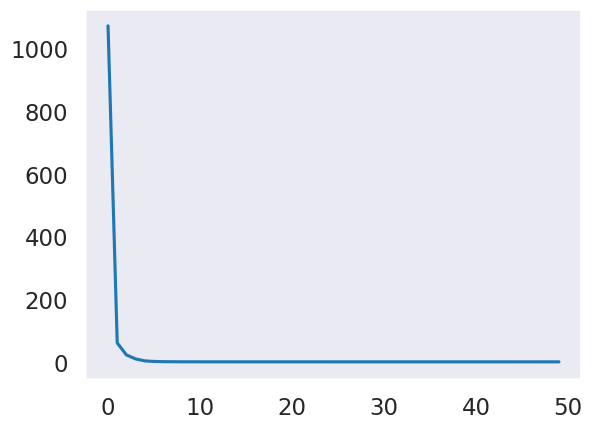

In [ ]:
plt.plot(perform.history['loss'])

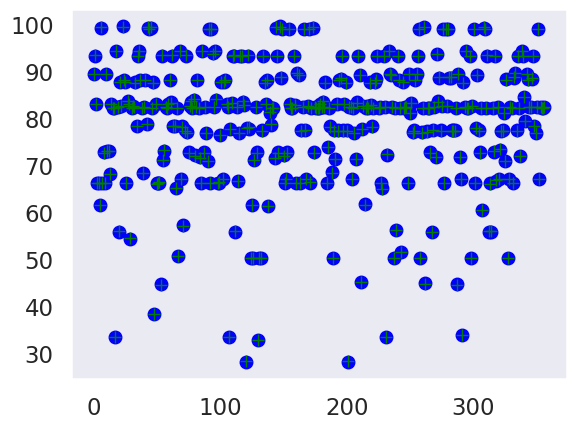

In [ ]:
plt.plot(pred_train,'bo',prediction,'g+')

Dự đoán chất lượng nước
Sau khi dự đoán chỉ số chất lượng nước, chúng ta phân loại nước dựa trên WQI và dự đoán chất lượng nước.

In [ ]:
spark_df = sqlContext.createDataFrame(df)

Mô hình hồi quy logistic
Ở đây chúng ta đang tạo một mô hình hồi quy logistic vì chúng ta không cần phải dự đoán một giá trị liên tục.

In [ ]:
from pyspark.ml.feature import StringIndexer

Vì cột chất lượng của chúng tôi chứa các giá trị ở định dạng chuỗi, nên trước tiên chúng tôi lập chỉ mục chúng bằng StringIndexer. Sau đó, dữ liệu cần thiết để dự đoán chất lượng nước được chuyển đổi sang dạng vector bằng VectorAssembler. Cuối cùng, chúng tôi chuẩn hóa dữ liệu bằng Normalizer.

In [ ]:
indexer = StringIndexer(inputCol="quality",outputCol="label")
vectorAssembler2 = VectorAssembler(inputCols=["npH","ndo","nbdo","nec","nna","nco","wqi"], outputCol="features2")
normalizer2 = Normalizer(inputCol="features2",outputCol="features_norm2")

Sau đó, nhập LogisticRegression từ pyspark.ml.classification và áp dụng vào dữ liệu đã chuẩn hóa của chúng tôi. Tiếp theo, nhập Pipeline từ pyspark.ml và đưa tất cả các bước đã thực hiện vào pipeline.

In [ ]:
from pyspark.ml.classification import LogisticRegression


In [ ]:
lor = LogisticRegression(featuresCol="features_norm2",labelCol="label",maxIter=10)


In [ ]:
pipeline2 = Pipeline(stages=[indexer,vectorAssembler2,normalizer2,lor])


In [ ]:
train_data,test_data=spark_df.randomSplit([0.8,0.2])


In [ ]:
model3 = pipeline2.fit(train_data)


In [ ]:
predictions2 = model3.transform(train_data)


Bây giờ chúng ta hãy kiểm tra dự đoán của mình.

In [ ]:
predictions2.select("label","prediction").show()


+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



Bây giờ chúng ta kiểm tra hiệu suất của mô hình.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
eval.evaluate(predictions2)

0.9859550561797753

Vì cột chất lượng ở định dạng chuỗi nên chúng tôi chuyển đổi dữ liệu dự đoán dưới dạng số thành giá trị chuỗi thực và so sánh với dữ liệu thực tế.

In [ ]:
names = ["Very Poor","Poor","Good","Unsuitable","Excellent"]


In [ ]:
predictions2.createOrReplaceTempView("predictions2_sql")


In [ ]:
pred = spark.sql("SELECT prediction from predictions2_sql")
pred = pred.rdd.map(lambda row : int(row.prediction)).collect()
qua = spark.sql("SELECT quality from predictions2_sql")
qua = qua.rdd.map(lambda row : row.quality).collect()

In [ ]:
for x in range(100):
    print("Predicted:", names[pred[x]], "Actual:", qua[x])

Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Poor Actual: Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predicted: Very Poor Actual: Very Poor
Predict